# 1번

### (1)

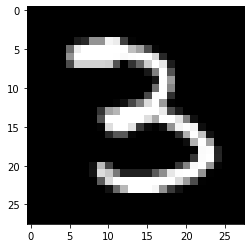

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

is_cuda = False
if torch.cuda.is_available():
    is_cuda = True

transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))])

train_dataset = datasets.MNIST('data/',train=True,transform=transformation,download=True)
test_dataset = datasets.MNIST('data/',train=False,transform=transformation,download=True)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True)

sample_data = next(iter(train_loader))

def plot_img(image):
    image = image.numpy()[0]
    mean = 0.1307
    std = 0.3081
    image = ((mean*image)+std)
    plt.imshow(image,cmap='gray')

plot_img(sample_data[0][2])

### (2)

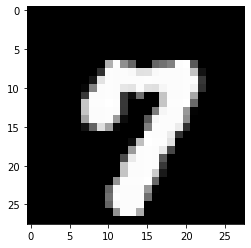

In [37]:
plot_img(sample_data[0][1])

### (3)

In [38]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,10,kernel_size=5)
        self.conv2 = nn.Conv2d(10,20,kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320,50)
        self.fc2 = nn.Linear(50,10)
    def forward(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x),2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
        x = x.view(-1,320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)
    
model = Net()
if is_cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.01)
data, target = next(iter(train_loader))
output = model(Variable(data.cuda()))

print(output.size())

torch.Size([32, 10])


### (4)

In [39]:
print(target.size())

torch.Size([32])


### (5)

In [40]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile = True
    running_loss = 0.0
    running_correct = 0
    for batch_idx, (data,target) in enumerate(data_loader):
        if is_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)
        running_loss += F.nll_loss(output,target,size_average=False).data
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100.*running_correct/len(data_loader.dataset)
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss, accuracy

train_losses, train_accuracy = [], []
val_losses, val_accuracy = [], []
for epoch in range(1,20):
    epoch_loss,epoch_accuracy = fit(epoch,model,train_loader,phase='training')
    val_epoch_loss, val_epoch_accuracy = fit(epoch,model,test_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

C:\Users\bhfux\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is  0.61 and training accuracy is 48843/60000      81.4
validation loss is  0.14 and validation accuracy is 9567/10000     95.67
training loss is  0.19 and training accuracy is 56583/60000     94.31
validation loss is 0.092 and validation accuracy is 9714/10000     97.14
training loss is  0.15 and training accuracy is 57391/60000     95.65
validation loss is  0.07 and validation accuracy is 9775/10000     97.75
training loss is  0.12 and training accuracy is 57834/60000     96.39
validation loss is 0.057 and validation accuracy is 9822/10000     98.22
training loss is  0.11 and training accuracy is 57993/60000     96.65
validation loss is 0.057 and validation accuracy is 9809/10000     98.09
training loss is   0.1 and training accuracy is 58222/60000     97.04
validation loss is 0.051 and validation accuracy is 9841/10000     98.41
training loss is 0.091 and training accuracy is 58416/60000     97.36
validation loss is 0.045 and validation accuracy is 9844/10000     98.44

### (6)

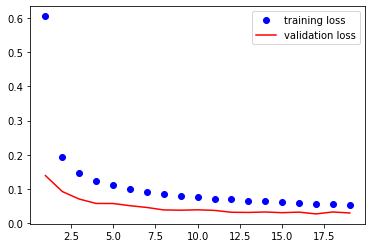

In [41]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label='training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label='validation loss')
plt.legend()
plt.show()

### (7)

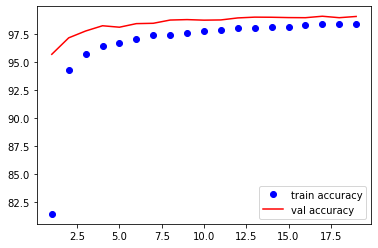

In [42]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label='val accuracy')
plt.legend()
plt.show()

# 2번

### (1)

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1,6,5)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    def forward(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        x = x.view(-1,self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self,x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### (3)

In [44]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 5, 5])


### (4)

In [45]:
input = torch.randn(1,1,32,32)
out = net(input)
print(out)

tensor([[-0.0003, -0.1102, -0.0790, -0.1403, -0.0489,  0.1543, -0.1296, -0.0638,
         -0.0369,  0.1045]], grad_fn=<AddmmBackward>)


### (5)

In [46]:
net.zero_grad()
out.backward(torch.randn(1,10))

output = net(input)
target = torch.randn(10)
target = target.view(1,-1)
criterion = nn.MSELoss()

loss = criterion(output,target)
print(loss)

tensor(0.9057, grad_fn=<MseLossBackward>)


### (6)

In [47]:
net.zero_grad()
print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])


### (7)

In [48]:
loss.backward()
print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad after backward
tensor([-0.0011, -0.0081,  0.0059,  0.0186, -0.0045,  0.0069])


### (8)

In [49]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data*learning_rate)

import torch.optim as optim

optimizer = optim.SGD(net.parameters(),lr=0.01)
optimizer.zero_grad()
output = net(input)
loss = criterion(output,target)
loss.backward()
optimizer.step()

# 3번

### (1)

In [50]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True,num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=4,shuffle=False,num_workers=2)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

Files already downloaded and verified
Files already downloaded and verified


### (2)

 frog  bird horse   cat


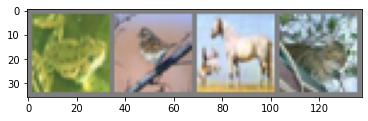

In [51]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img/2+0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))

dataiter = iter(trainloader)
images,labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s'%classes[labels[j]] for j in range(4)))

### (3)

In [52]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i%1000 == 999:
            print('[%d,%5d] loss: %.3f'%(epoch+1,i+1,running_loss/1000))
            running_loss = 0.0
print('Finished Training')

[1, 1000] loss: 2.297
[1, 2000] loss: 2.103
[2, 1000] loss: 1.823
[2, 2000] loss: 1.706
Finished Training


### (4)

GroundTruth:   cat  ship  ship plane


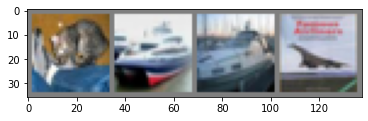

In [53]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth:',' '.join('%5s'%classes[labels[j]] for j in range(4)))

### (5)

In [54]:
outputs = net(images)
_,predicted = torch.max(outputs,1)
print('Predicted: ',' '.join('%5s'%classes[predicted[j]] for j in range(4)))

Predicted:   bird  ship  ship  ship


### (6)

In [55]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images,labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test imabes: %d %%'%(100*correct/total))

Accuracy of the network on the 10000 test imabes: 38 %


### (7)

In [56]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs,1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%'%(classes[i], 100*class_correct[i]/class_total[i]))

Accuracy of plane : 58 %
Accuracy of   car : 38 %
Accuracy of  bird : 46 %
Accuracy of   cat : 10 %
Accuracy of  deer :  6 %
Accuracy of   dog : 33 %
Accuracy of  frog : 33 %
Accuracy of horse : 59 %
Accuracy of  ship : 51 %
Accuracy of truck : 47 %


# 4번

# 5번

### (1)

### (2)

# 6번

In [23]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9680 sha256=991694d9a567722082d9ab1f3b9322b9812d1c11d15ff83ea310f113e7d15984
  Stored in directory: c:\users\bhfux\appdata\local\pip\cache\wheels\bd\a8\c3\3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [25]:
import os
import wget


def bar_custom(current, total, width=80):
    progress = "Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total)
    return progress


def download_imagenet(root='D:\data\example'):
    """
    download_imagenet validation set
    :param img_dir: root for download imagenet
    :return:
    """

    # make url
    val_url = 'https://image-net.org/data/ILSVRC/2012/ILSVRC2012_img_val.tar'
    devkit_url = 'https://image-net.org/data/ILSVRC/2012/ILSVRC2012_devkit_t12.tar.gz'

    print("Download...")
    os.makedirs(root, exist_ok=True)
    wget.download(url=val_url, out=root, bar=bar_custom)
    print('')
    wget.download(url=devkit_url, out=root, bar=bar_custom)
    print('')
    print('done!')

In [26]:
download_imagenet('./Imagenet')

Download...
Downloading: 100% [6744924160 / 6744924160] bytes
Downloading: 100% [2568145 / 2568145] bytes
done!


In [80]:
from torchvision.models import alexnet, vgg19, resnet101, densenet121

model_a = alexnet(pretrained=True)
model_v = vgg19(pretrained=True)
model_r = resnet101(pretrained=True)
model_d = densenet121(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to C:\Users\bhfux/.cache\torch\hub\checkpoints\resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\bhfux/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [83]:
from tensorflow.keras import Sequential

model_aa = Sequential([model_a,Flatten(),Dense(64,activation='relu'),Dense(1,'sigmoid')])
model_vv = Sequential([model_v,Flatten(),Dense(64,activation='relu'),Dense(1,'sigmoid')])
model_rr = Sequential([model_r,Flatten(),Dense(64,activation='relu'),Dense(1,'sigmoid')])
model_dd = Sequential([model_d,Flatten(),Dense(64,activation='relu'),Dense(1,'sigmoid')])

AttributeError: type object 'h5py.h5.H5PYConfig' has no attribute '__reduce_cython__'

# 7번

### (1)

In [57]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.conv1 = nn.Conv2d(3,32,3)
        self.conv2 = nn.Conv2d(32,32,3)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(32,32,3)
        self.conv4 = nn.Conv2d(32,32,3)
        self.pool2 = nn.MaxPool2d(2,2)
        self.fc = nn.Linear(32*5*5,10)
    def forward(self,x):
        x = self.conv1(x)
        x = self.pool1(F.relu(self.conv2(x)))
        x = self.conv3(x)
        x = self.pool2(F.relu(self.conv4(x)))
        x = x.view(-1,32*5*5)
        x = self.fc(x)
        return x

net = Model()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=.001,momentum=.9)

net.train()

for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
        inputs,labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 1000 == 999:
            print('[%d, %5d] loss : %.3f'%(epoch+1,i+1,running_loss/1000))
            running_loss = 0.0

print('Finsih!')

[1,  1000] loss : 2.102
[1,  2000] loss : 1.821
[2,  1000] loss : 1.610
[2,  2000] loss : 1.546
[3,  1000] loss : 1.411
[3,  2000] loss : 1.369
[4,  1000] loss : 1.264
[4,  2000] loss : 1.237
[5,  1000] loss : 1.133
[5,  2000] loss : 1.166
Finsih!


In [58]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images,labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test imabes: %d %%'%(100*correct/total))

Accuracy of the network on the 10000 test imabes: 63 %


### (2)

In [59]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=0.001,betas=(.9,.999))

for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i%1000 == 999:
            print('[%d,%5d] loss: %.3f'%(epoch+1,i+1,running_loss/1000))
            running_loss = 0.0
print('Finished Training')

[1, 1000] loss: 1.993
[1, 2000] loss: 1.775
[2, 1000] loss: 1.569
[2, 2000] loss: 1.519
Finished Training


In [60]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images,labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test imabes: %d %%'%(100*correct/total))

Accuracy of the network on the 10000 test imabes: 48 %


### (3)

In [61]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32,padding=4),
    transforms.ToTensor(),
    transforms.Normalize((.5,.5,.5),(.5,.5,.5))])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5,.5,.5),(.5,.5,.5))])

trainset = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True,num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform_test)
testloader = torch.utils.data.DataLoader(testset,batch_size=4,shuffle=False,num_workers=2)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

Files already downloaded and verified
Files already downloaded and verified


In [62]:
net = Model()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=.001,momentum=.9)

net.train()

for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
        inputs,labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 1000 == 999:
            print('[%d, %5d] loss : %.3f'%(epoch+1,i+1,running_loss/1000))
            running_loss = 0.0

print('Finsih!')

[1,  1000] loss : 2.146
[1,  2000] loss : 1.911
[1,  3000] loss : 1.753
[1,  4000] loss : 1.694
[1,  5000] loss : 1.601
[1,  6000] loss : 1.579
[1,  7000] loss : 1.545
[1,  8000] loss : 1.479
[1,  9000] loss : 1.445
[1, 10000] loss : 1.475
[1, 11000] loss : 1.428
[1, 12000] loss : 1.387
[2,  1000] loss : 1.366
[2,  2000] loss : 1.335
[2,  3000] loss : 1.355
[2,  4000] loss : 1.304
[2,  5000] loss : 1.271
[2,  6000] loss : 1.259
[2,  7000] loss : 1.250
[2,  8000] loss : 1.250
[2,  9000] loss : 1.232
[2, 10000] loss : 1.212
[2, 11000] loss : 1.241
[2, 12000] loss : 1.229
[3,  1000] loss : 1.188
[3,  2000] loss : 1.204
[3,  3000] loss : 1.175
[3,  4000] loss : 1.218
[3,  5000] loss : 1.182
[3,  6000] loss : 1.171
[3,  7000] loss : 1.185
[3,  8000] loss : 1.177
[3,  9000] loss : 1.188
[3, 10000] loss : 1.171
[3, 11000] loss : 1.169
[3, 12000] loss : 1.166
[4,  1000] loss : 1.145
[4,  2000] loss : 1.150
[4,  3000] loss : 1.164
[4,  4000] loss : 1.140
[4,  5000] loss : 1.108
[4,  6000] loss 

In [63]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images,labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test imabes: %d %%'%(100*correct/total))

Accuracy of the network on the 10000 test imabes: 62 %


### (4)

In [72]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.norm1 = nn.BatchNorm2d(num_features=6)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.norm2 = nn.BatchNorm2d(num_features=16)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    def forward(self,x):
        x = self.norm1(self.conv1(x))
        x = self.pool(F.relu(x))
        x = self.norm2(self.conv2(x))
        x = self.pool(F.relu(x))
        x = x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=.9)

net.train()
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i%1000 == 999:
            print('[%d,%5d] loss: %.3f'%(epoch+1,i+1,running_loss/1000))
            running_loss = 0.0
print('Finished Training')

[1, 1000] loss: 2.147
[1, 2000] loss: 1.947
[1, 3000] loss: 1.859
[1, 4000] loss: 1.819
[1, 5000] loss: 1.765
[1, 6000] loss: 1.717
[1, 7000] loss: 1.661
[1, 8000] loss: 1.683
[1, 9000] loss: 1.642
[1,10000] loss: 1.628
[1,11000] loss: 1.637
[1,12000] loss: 1.621
[2, 1000] loss: 1.567
[2, 2000] loss: 1.542
[2, 3000] loss: 1.531
[2, 4000] loss: 1.539
[2, 5000] loss: 1.553
[2, 6000] loss: 1.511
[2, 7000] loss: 1.488
[2, 8000] loss: 1.477
[2, 9000] loss: 1.482
[2,10000] loss: 1.472
[2,11000] loss: 1.454
[2,12000] loss: 1.460
Finished Training


In [73]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images,labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test imabes: %d %%'%(100*correct/total))

Accuracy of the network on the 10000 test imabes: 51 %


### (5)

In [66]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=.9)

net.train()
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = F.nll_loss(F.log_softmax(outputs,dim=1),labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i%1000 == 999:
            print('[%d,%5d] loss: %.3f'%(epoch+1,i+1,running_loss/1000))
            running_loss = 0.0
print('Finished Training')

[1, 1000] loss: 2.303
[1, 2000] loss: 2.236
[1, 3000] loss: 2.024
[1, 4000] loss: 1.921
[1, 5000] loss: 1.804
[1, 6000] loss: 1.740
[1, 7000] loss: 1.708
[1, 8000] loss: 1.705
[1, 9000] loss: 1.668
[1,10000] loss: 1.632
[1,11000] loss: 1.625
[1,12000] loss: 1.614
[2, 1000] loss: 1.578
[2, 2000] loss: 1.573
[2, 3000] loss: 1.542
[2, 4000] loss: 1.536
[2, 5000] loss: 1.489
[2, 6000] loss: 1.510
[2, 7000] loss: 1.488
[2, 8000] loss: 1.483
[2, 9000] loss: 1.469
[2,10000] loss: 1.479
[2,11000] loss: 1.433
[2,12000] loss: 1.465
Finished Training


In [67]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images,labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test imabes: %d %%'%(100*correct/total))

Accuracy of the network on the 10000 test imabes: 49 %


### (6)

In [69]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=.9,weight_decay=.01)

net.train()
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i%1000 == 999:
            print('[%d,%5d] loss: %.3f'%(epoch+1,i+1,running_loss/1000))
            running_loss = 0.0
print('Finished Training')

[1, 1000] loss: 2.299
[1, 2000] loss: 2.173
[1, 3000] loss: 2.045
[1, 4000] loss: 1.965
[1, 5000] loss: 1.921
[1, 6000] loss: 1.853
[1, 7000] loss: 1.832
[1, 8000] loss: 1.814
[1, 9000] loss: 1.769
[1,10000] loss: 1.770
[1,11000] loss: 1.748
[1,12000] loss: 1.748
[2, 1000] loss: 1.747
[2, 2000] loss: 1.710
[2, 3000] loss: 1.723
[2, 4000] loss: 1.707
[2, 5000] loss: 1.655
[2, 6000] loss: 1.687
[2, 7000] loss: 1.663
[2, 8000] loss: 1.662
[2, 9000] loss: 1.631
[2,10000] loss: 1.656
[2,11000] loss: 1.596
[2,12000] loss: 1.636
Finished Training


In [70]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images,labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test imabes: %d %%'%(100*correct/total))

Accuracy of the network on the 10000 test imabes: 41 %


### (7)

# 8번

### (1)

### (2)

### (3)

### (4)

# 9번

# 10번

In [24]:
import torch
import numpy as np

output = torch.Tensor(np.transpose([.4,2.,.001,.32]))
print('result :',F.softmax(output))

result : tensor([0.1325, 0.6563, 0.0889, 0.1223])


<ipython-input-24-3f89c6ee599f>:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print('result :',F.softmax(output))


# 11번

In [23]:
import torch

def mse(output,target):
    return ((target-output)**2).mean()
def cross_entropy(output,target):
    return -(target*torch.log2(output)+(1-target)*torch.log2(1-output)).mean()
def log_likelihood(output,target):
    loss = 0
    for i, j in zip(output, target):
        if j == 0:
            pass
        else:
            loss += -torch.log2(i)
    return loss

output = torch.Tensor(np.transpose([.001,.9,.001,.098]))
target = torch.Tensor(np.transpose([0,0,0,1]))
mse = mse(output,target)
cross_entropy = cross_entropy(output,target)
log = log_likelihood(output,target)
print('mse :',mse)
print('cross_entropy :',cross_entropy)
print('log likelihood :',log)

mse : tensor(0.4059)
cross_entropy : tensor(1.6690)
log likelihood : tensor(3.3511)
